# Variational Quantum Eigensolver

A common application of the Variational Quantum Eigensolver (VQE) algorithm is to compute the ground state energy of a molecular system. The code below demonstrates how to perform classical preprocessing for a $H_2$ molecule (i.e. obtain the integrals from a Hartree-Fock computation to build the molecular Hamiltonian), prepare the initial Hartree-Fock state on the quantum register, add the parameterized UCCSD ansatz to the kernel, and select the COBYLA optimizer.  We are then ready to call `cudaq:vqe` to estimate the minimum energy of the system.

In [1]:
#!pip install openfermionpyscf==0.5

In [2]:
import cudaq

cudaq.set_target("nvidia")

The problem of interest here is a chain of hydrogen atoms seperated along the z-axis at a fixed interval called the bond distance. 

The interatomic electrostatic forces due to the electrons and protons and the shielding by the neutrons creates a chemical system whose energy can be minimised to find a stable configuration. 

Let us first begin by defining the molecule and other metadata about the problem.


In [3]:
# Number of hydrogen atoms.
hydrogen_count = 2

# Distance between the atoms in Angstroms.
bond_distance = 0.7474

# Define a linear chain of Hydrogen atoms
geometry = [("H", (0, 0, i * bond_distance)) for i in range(hydrogen_count)]

molecule, data = cudaq.chemistry.create_molecular_hamiltonian(geometry, "sto-3g", 1, 0)

electron_count = data.n_electrons
num_qubits = 2 * data.n_orbitals

In [4]:
## Classical solution
import numpy as np

matrix = np.array(molecule.to_matrix())
print("Ground state energy:", np.linalg.eigvalsh(matrix)[0])

Ground state energy: -1.137175710240685


We now generate a Unitary Coupled-Cluster Singles and Doubles (UCCSD) ansatz from the template provided by CUDA-Q.  

In [5]:
@cudaq.kernel
def kernel(thetas: list[float]):

    qubits = cudaq.qvector(num_qubits)

    for i in range(electron_count):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_count, num_qubits)


parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count, num_qubits)

### Using CUDA-Q Optimizers

We use the builtin optimizers within CUDA-Q for the minimization procedure.

In [6]:
optimizer = cudaq.optimizers.COBYLA()

energy, parameters = cudaq.vqe(
    kernel, molecule, optimizer, parameter_count=parameter_count
)

print(energy)

-1.1371740035195181


### Integration with Third-Party Optimizers

We can also integrate popular libraries like scipy with CUDA-Q. 

In [7]:
from scipy.optimize import minimize

# Define a function to minimize
def cost(theta):

    exp_val = cudaq.observe(kernel, molecule, theta).expectation()

    return exp_val

exp_vals = []

def callback(xk):
    exp_vals.append(cost(xk))


# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, np.pi, parameter_count)

# Use the scipy optimizer to minimize the function of interest
result = minimize(cost, x0, method="COBYLA", callback=callback, options={"maxiter": 40})

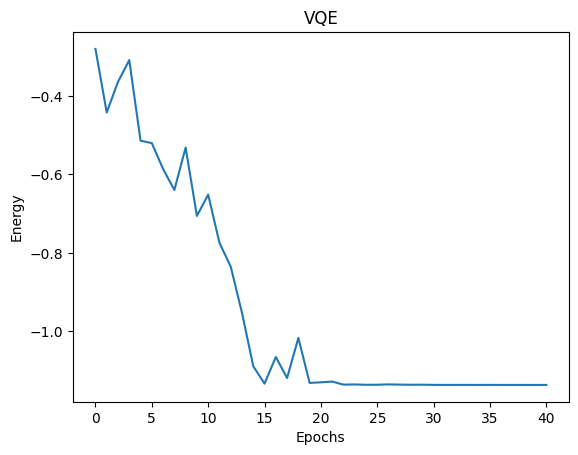

In [8]:
import matplotlib.pyplot as plt

plt.plot(exp_vals)
plt.xlabel("Epochs")
plt.ylabel("Energy")
plt.title("VQE")
plt.show()

<div class="alert alert-block alert-success"> 

## Exercise

Increase `hydrogen_count` to `4`. Run the variational quantum eigensolver and try other optimizers and/or ansatz. 
</div>

In [ ]:
# Write your codes here

In [9]:
print(cudaq.__version__)

CUDA-Q Version 0.8.0 (https://github.com/NVIDIA/cuda-quantum 5f63a898a1c4af1affd293fcc86220b683436f57)
